In [1]:
from dvt.core import FrameInput
from dvt.core import DataExtraction

from dvt.pipeline.csv import VideoCsvPipeline

#importing different annotators
from dvt.annotate.diff import DiffAnnotator
from dvt.core import DataExtraction, ImageInput
from dvt.annotate.color import ColorHistogramAnnotator, DominantColorAnnotator

%pylab inline

import numpy as np
import scipy as sp
import pandas as pd
import json

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
from os.path import join, basename

Populating the interactive namespace from numpy and matplotlib


In [2]:
# applying annotators to a video file
# create a custom set of annotations on your data. 

# To start, we need to create a FrameInput object that points to our video file. 
# This object handles grabbing frames from the input dataset.

fi = FrameInput(input_path=join("bestdressed videos", "$1 THRIFT HAUL (try on goodwill outlet haul)-oNXSyNbrXrk.mp4"))

In [3]:
# Next, we construct a data extraction object by providing out input object as an input. 
# There are various options that are possible here, such as providing the location of an audio file, 
# but for now we will just use our input video.

dextraction = DataExtraction(fi)

In [4]:
# With the input and extraction objects created, we can now pass a list of annotator objects and run them over the input. 
# Here, we will use an annotator called DiffAnnotator. 
# The algorithm will compute differences between succesive frames; 
# by setting the quantiles input to 50, we indicate that we want to output the median differences between these frames.

dextraction.run_annotators([
    DiffAnnotator(quantiles=[50])
])

In [5]:
dt = dextraction.get_data() #using get_data will let us retreive the results stored inside of the data extraction object
dt.keys()

# Note that the algorithm has produced our desired annotations (called "diff") 
# as well as a special set of annotations called "meta".

odict_keys(['meta', 'diff'])

In [6]:
dt['meta']

# As we input only a single video file, the metadata record contains only a single line. 
# Printing it out, we see that it gives some basic information about the video file:

,type,fps,frames,height,width,input_path,input_bname,input_filename,input_file_extension
0,video,25.0,17663,720,1280,C:\Users\Gebruiker\Documents\Digital Humanitie...,$1 THRIFT HAUL (try on goodwill outlet haul)-o...,$1 THRIFT HAUL (try on goodwill outlet haul)-o...,.mp4


In [7]:
dt['diff']

# The difference annotator gives information about each frame in the input, 
# such as the average value (how bright the image is) as well as the median difference between each frame and the next.

# The column "q50" gives the pixel difference between each frame 
# and "h50" gives the histogram difference between colors in each image. 
# Used together, we can try to predict when there is a shot break in the source video.

,frame,avg_value,q50,h50
0,0,128.314532,0.0,0.017578
1,1,128.949536,0.0,0.029496
2,2,129.295929,0.0,0.072374
3,3,126.502274,0.0,0.021936
4,4,127.637003,0.0,0.012243
...,...,...,...,...
17659,17659,218.726074,0.0,0.000000
17660,17660,218.726074,0.0,0.000000
17661,17661,218.726074,0.0,0.000000
17662,17662,218.726074,35.0,0.000000


In [8]:
# q50 of 3 indicates the pixel difference necessary for it to be considered a new shot (this is the standard one)

from dvt.aggregate.cut import CutAggregator
dextraction.run_aggregator(CutAggregator(cut_vals={'q50': 3}, min_len=10))

In [9]:
dt = dextraction.get_data()
dt.keys()
#collections.OrderedDict

odict_keys(['meta', 'diff', 'cut'])

In [10]:
dt['meta']

,type,fps,frames,height,width,input_path,input_bname,input_filename,input_file_extension
0,video,25.0,17663,720,1280,C:\Users\Gebruiker\Documents\Digital Humanitie...,$1 THRIFT HAUL (try on goodwill outlet haul)-o...,$1 THRIFT HAUL (try on goodwill outlet haul)-o...,.mp4


In [11]:
dt['cut']

,frame_start,frame_end
0,0,163
1,164,175
2,176,187
3,188,199
4,200,237
...,...,...
269,16839,17093
270,17094,17123
271,17124,17173
272,17174,17662


In [12]:
dt['cut']['length_sec'] = ((dt['cut']['frame_end'] - dt['cut']['frame_start']) / dt['meta']['fps'].values)
dt['cut']

,frame_start,frame_end,length_sec
0,0,163,6.52
1,164,175,0.44
2,176,187,0.44
3,188,199,0.44
4,200,237,1.48
...,...,...,...
269,16839,17093,10.16
270,17094,17123,1.16
271,17124,17173,1.96
272,17174,17662,19.52


In [13]:
video_name = dt['meta']['input_filename'].values
total_frames = dt['meta']['frames'].values # this and the above are np array values which are shown
number_shots = len(dt['cut'])

In [14]:
# df = pd.DataFrame({'Name':video_name, 'frames':total_frames, 'number_shots':number_shots incl. more and more information})
# include info gotten from later dictionaries and arrays and transform into pd df in one go

In [15]:
#investigating the use of color across time and it's impact on viewer attraction

def conf_int(vals, ndigits=1):
    se = 1.96 * np.sqrt(np.var(vals) / len(vals))
    mu = np.mean(vals)
    return [round(mu - se, ndigits=ndigits), round(mu + se, ndigits=ndigits)]


plt.rcParams["figure.figsize"] = (8,8)

In [16]:
img_paths = [join("Screenshots", "$1 THRIFT HAUL (try on goodwill outlet haul)-oNXSyNbrXrk", x) for x in os.listdir(join("Screenshots", "$1 THRIFT HAUL (try on goodwill outlet haul)-oNXSyNbrXrk"))]

# accessing the VLC screenshots made per video

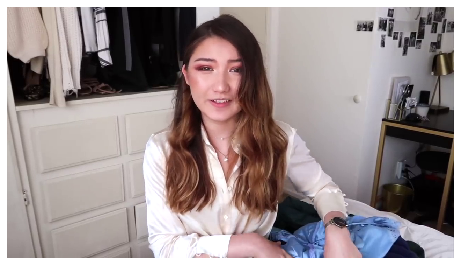

In [17]:
#checking if the right file was accessed 

img = imread(img_paths[(20)]) #specified image index in specified image folder
plt.imshow(img) #shows image with plot axes
_=plt.axis("off") #shows image without plot axes

#not necessary for the rest of the processing code

In [18]:
input_obj = ImageInput(input_paths=img_paths)
dextra = DataExtraction(input_obj)
dextra.run_annotators([
    ColorHistogramAnnotator(num_buckets=(16, 4, 8)),
    DominantColorAnnotator()
])

#output contains metadata, information about the 5 dominant colors in each poster 
# as well as info about the specific hues, values and saturations

dt = dextra.get_json()

dt.keys() #output shows dictionary keys

dict_keys(['meta', 'colorhist', 'domcolor'])

In [19]:
dt['domcolor']

[{'dominant_colors': ['#7b6668', '#432f2b', '#aa9a9b', '#120d0e', '#c9bebf'],
  'frame': 0},
 {'dominant_colors': ['#120d0e', '#a49494', '#c3b8b9', '#442d2a', '#756264'],
  'frame': 1},
 {'dominant_colors': ['#b7abaa', '#513b36', '#dad1d5', '#151011', '#938381'],
  'frame': 2},
 {'dominant_colors': ['#fbfaf8', '#5d6162', '#e9d0cd', '#242222', '#0040c2'],
  'frame': 3},
 {'dominant_colors': ['#ad856d', '#fdfdfd', '#68463e', '#ecd2d2', '#beaca5'],
  'frame': 4},
 {'dominant_colors': ['#e3dddd', '#883e43', '#feffff', '#eccbcb', '#f0edf2'],
  'frame': 5},
 {'dominant_colors': ['#efeaf2', '#e8d2d3', '#cfb9b8', '#342b29', '#ac7877'],
  'frame': 6},
 {'dominant_colors': ['#c3ad9f', '#e8d0ce', '#f8f7f9', '#765b53', '#392e2c'],
  'frame': 7},
 {'dominant_colors': ['#f6f4fb', '#553735', '#b2948d', '#e4cbd2', '#936e68'],
  'frame': 8},
 {'dominant_colors': ['#cfc8ca', '#140f0e', '#7f7075', '#b1a3a3', '#4e3630'],
  'frame': 9},
 {'dominant_colors': ['#b0a2a2', '#4b3630', '#7e6f74', '#130e0f', '#cf

In [20]:
#aggregating information across the corpus
#loading the fully annotated version of the corpus (in the notebook 4 this is in a json file already)

# complex histogram which require some processing

#counting the number of pixels that are dark, heavily saturated, red, and white
#restructure the dominant color info to better integrate into a rectangular dataset

paths = [basename(x['paths']) for x in dt['meta']]

dark_count = np.zeros((len(dt['meta'])))
saturated_count = np.zeros((len(dt['meta'])))
red_count = np.zeros((len(dt['meta'])))
white_count= np.zeros((len(dt['meta'])))
for i, hist in enumerate(dt['colorhist']):
    img_hist = np.array(hist['hsv']).reshape((16, 4, 8))
    dark_count[i] = np.sum(img_hist[:,:,:3])
    saturated_count[i] = np.sum(img_hist[:,3,4:])
    red_count[i] = np.sum(img_hist[:2,2:,4:])
    white_count[i] = np.sum(img_hist[:,0,4:])

    
dom_cols = []
for i, dc in enumerate(dt['domcolor']):
    dom_cols.append(dc['dominant_colors'])

In [21]:
# converting values into a structured table

color_info = pd.DataFrame({
    'img': paths,
    'dark_perc': dark_count / (594 * 4),
    'saturated_perc': saturated_count / (594 * 4), 
    'red_perc': red_count / (594 * 4),
    'white_perc': white_count/ (594 * 4),
    'dom_cols': dom_cols
})
color_info

,img,dark_perc,saturated_perc,red_perc,white_perc,dom_cols
0,scene00001.png,103.667508,0.000000,0.520202,222.414562,"[#7b6668, #432f2b, #aa9a9b, #120d0e, #c9bebf]"
1,scene00061.png,102.989478,0.001263,1.168350,224.044613,"[#120d0e, #a49494, #c3b8b9, #442d2a, #756264]"
2,scene00121.png,106.686869,0.000000,1.001684,228.029882,"[#b7abaa, #513b36, #dad1d5, #151011, #938381]"
3,scene00181.png,131.021465,0.000000,3.439394,221.236111,"[#fbfaf8, #5d6162, #e9d0cd, #242222, #0040c2]"
4,scene00241.png,12.505051,0.043771,24.924663,266.197811,"[#ad856d, #fdfdfd, #68463e, #ecd2d2, #beaca5]"
...,...,...,...,...,...,...
289,scene17341.png,0.000000,0.000000,0.000000,387.878788,"[#f1ced3, #fdf3f1, #0040c2, #0040c2, #0040c2]"
290,scene17401.png,0.000000,0.000000,0.000000,387.878788,"[#f2cfd4, #0040c2, #0040c2, #0040c2, #0040c2]"
291,scene17461.png,0.000000,0.000000,0.000000,387.878788,"[#f1ced3, #fbedef, #0040c2, #0040c2, #0040c2]"
292,scene17521.png,0.000000,0.000000,0.000000,387.878788,"[#faeced, #f1ced3, #0040c2, #0040c2, #0040c2]"


In [22]:
dark_perc_std = color_info['dark_perc'].std()
dark_perc_mean = color_info['dark_perc'].mean()

saturated_perc_std = color_info['saturated_perc'].std()
saturated_perc_mean = color_info['saturated_perc'].mean()

red_perc_std = color_info['red_perc'].std()
red_perc_mean = color_info['red_perc'].mean()

white_perc_std = color_info['white_perc'].std()
white_perc_mean = color_info['white_perc'].mean()

In [23]:
#accessing json file for additional meta-data --> likes, dislikes, shares, views, date posted 

In [24]:
import json
import glob

In [25]:
with open ("C:/Users/Gebruiker/Documents/Digital Humanities/block 3/Thesis Lab/scraping YouTube data/metadata/$1 THRIFT HAUL (try on goodwill outlet haul)-oNXSyNbrXrk.info.json") as json_file:
    metadata = json.load(json_file)

In [26]:
metadata

{'id': 'oNXSyNbrXrk',
 'uploader': 'bestdressed',
 'uploader_id': 'UCnQhwPVwcP-DnbUZtIMrupw',
 'uploader_url': 'http://www.youtube.com/channel/UCnQhwPVwcP-DnbUZtIMrupw',
 'channel_id': 'UCnQhwPVwcP-DnbUZtIMrupw',
 'channel_url': 'http://www.youtube.com/channel/UCnQhwPVwcP-DnbUZtIMrupw',
 'upload_date': '20180315',
 'license': None,
 'creator': None,
 'title': '$1 THRIFT HAUL (try on goodwill outlet haul)',
 'alt_title': None,
 'thumbnail': 'https://i.ytimg.com/vi/oNXSyNbrXrk/maxresdefault.jpg',
 'description': 'if you need a website! ➭ https://www.squarespace.com/bestdressed\nmy online store ➭ https://www.bestdressedstore.com/\ninstagram ➭ https://www.instagram.com/best.dressed\nsubscribe for more thrift hauls! ➭ http://bit.ly/bestdressedfam\n\nIn which I show y\'all what I got on my very first trip to a Goodwill outlet (because regular thrifting wasn\'t cheap enough) in a good ol try on thrift haul. This week\'s thrift finds include puffer and bomber jackets, a kimono thing, and (pote

In [27]:
category = metadata['categories']
# categories = "".join(category)
# print(categories)
tags = metadata['tags']
view_count = metadata['view_count']
like_count = metadata['like_count']
dislike_count = metadata['dislike_count']
upload_date = metadata['upload_date']

In [28]:
tags_str = ", ".join(tags)

In [29]:
print(tags_str)

$1 thrift haul, thrift haul 2018, thrift haul try on, thrift haul goodwill, thrift haul goodwill outlet, thrift haul goodwill 2018, goodwill outlet, goodwill haul, try on thrift haul, try on thrift haul 2018, try on thrift haul goodwill, try on goodwill haul, thrift haul designer, thrift store haul designer, thrifting haul 2018, thrift haul for resale, spring thrift haul, thrift store haul, thrift store finds, cheap thrift haul, thrift haul


20180315


# Saving the files

In [30]:
# save pd to csv file for general info specific to this video
color_info.to_csv('C:/Users/Gebruiker/Documents/Digital Humanities/Thesis/dvt bestdressed csv/$1 THRIFT HAUL (try on goodwill outlet haul)-oNXSyNbrXrk.csv')

In [33]:
df = pd.DataFrame({'Name':video_name, 'upload_date':upload_date, 'category':category, 'view_count':view_count, 'like_count':like_count, 'dislike_count':dislike_count, 'frames':total_frames, 'number_shots':number_shots, 'dark_perc_std':dark_perc_std, 'dark_perc_mean':dark_perc_mean, 'saturated_perc_std':saturated_perc_std, 'saturated_perc_mean':saturated_perc_mean, 'red_perc_std':red_perc_std, 'red_perc_mean':red_perc_mean, 'white_perc_std':white_perc_std, 'white_perc_mean':white_perc_mean, 'tags':tags_str})

In [34]:
df

,Name,upload_date,category,view_count,like_count,dislike_count,frames,number_shots,dark_perc_std,dark_perc_mean,saturated_perc_std,saturated_perc_mean,red_perc_std,red_perc_mean,white_perc_std,white_perc_mean,tags
0,$1 THRIFT HAUL (try on goodwill outlet haul)-o...,20180315,Howto & Style,782897,25090,229,17663,274,46.829203,83.377024,9.79147,3.005607,7.95217,2.060965,54.321043,254.544282,"$1 thrift haul, thrift haul 2018, thrift haul ..."


In [35]:
df.to_csv('C:/Users/Gebruiker/Documents/Digital Humanities/block 3/Thesis Lab/scraping YouTube data/data for video analysis.csv')